## 千兆病理图像癌细胞转移检测
## Detecting Cancer Metastases on Gigapixel Pathology Images

In [1]:
ls

Detecting_Cancer_Metastases_on_Gigapixel_Pathology_Images.ipynb
Detecting_Cancer_metastases/
Mitosis_Detecting.ipynb
camelyon/
data_preprocessing-latest.ipynb
data_preprocessing-nerd.ipynb
data_preprocessing.ipynb
data_preprocessing_of_camelyon/
data_processing.ipynb
download_Inception_V3.ipynb
retrain.ipynb


In [2]:
pwd

'/atlas/home/zwpeng/paper_rebuild'

In [3]:
import openslide
import numpy as np
from pylab import *

# 读取包含有肿瘤区域的大图（全切片病理图像）
origin_images_path = "/atlas/home/zwpeng/paper_rebuild/camelyon/train/tumor/origin_images/Tumor_005.tif"
origin_slide = openslide.open_slide(origin_images_path)

# 读取该肿瘤区域的标注图
annotation_images_path = "/atlas/home/zwpeng/paper_rebuild/camelyon/train/tumor/annotation_images/Tumor_005_Mask.tif"
mask_slide = openslide.open_slide(annotation_images_path)

In [4]:
# origin_slide.level_count,origin_slide.level_dimensions,origin_slide.level_downsamples     #查看病理图片的金字塔结构

(10,
 ((97792, 219648),
  (49152, 110080),
  (24576, 55296),
  (12288, 27648),
  (6144, 13824),
  (3072, 7168),
  (1536, 3584),
  (1024, 2048),
  (512, 1024),
  (512, 512)),
 (1.0,
  1.9924660852713179,
  3.9756944444444446,
  7.951388888888889,
  15.902777777777779,
  31.238095238095237,
  62.476190476190474,
  101.375,
  202.75,
  310.0))

In [5]:
# mask_slide.level_count,mask_slide.level_dimensions,mask_slide.level_downsamples     #查看标注图片的金字塔结构

(8,
 ((97792, 219648),
  (48896, 109824),
  (24448, 54912),
  (12224, 27456),
  (6112, 13728),
  (3056, 6864),
  (1528, 3432),
  (764, 1716)),
 (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0))

### 首先找到感兴趣区域

In [4]:
level=6
origin_size = origin_slide.dimensions
origin_widths = origin_size[0]
origin_heights = origin_size[1]

object_size = origin_slide.level_dimensions[level]
object_widths = int(object_size[0])
object_heights = object_size[1]


In [5]:
# 方法三：通过获取每一块区域的像素值R G B各自的平均数，然后相减，设置一个阈值，将噪点（墨迹）和有效区　分开

import time
from pylab import *
import numpy as np

start_time = time.clock()
level = 6

rgb_list_y = list()
rgb_list_x = list()
rgb_var_x = []
rgb_var_y = []
rgb_var_xi = []
rgb_var_yi = []

# 寻找有效区域的y值、高度
for k in range(100):
    slide = origin_slide.read_region((0, k*origin_heights//100), level, (object_widths, object_heights//50)) 
    slide_arr = array(slide.convert("RGB"))
    arrR = np.mean(slide_arr[:,:,:1])
    arrG = np.mean(slide_arr[:,:,1:2])
    arrB = np.mean(slide_arr[:,:,2:3])
    rgb_list_y.append((arrR,arrG,arrB))
for i,rgbVar in enumerate(rgb_list_y):
    rgb_var_y.append(np.var(rgbVar))
    if np.var(rgbVar)>=1:
        rgb_var_yi.append(i)

print(rgb_var_yi)
effective_y = min(rgb_var_yi)*origin_heights//100        #有效区域的左上顶点y坐标找到了
effective_heights = (max(rgb_var_yi)-min(rgb_var_yi))*origin_heights//100 + origin_heights//50  #有效区域的高度也出来了
print("有效区域的ｙ值是：%d" %effective_y, "有效区域的高度是：%d" %effective_heights)

# 寻找有效区域的x值、宽度
for j in range(100):
    slide = origin_slide.read_region((j*origin_widths//100, effective_y), level, 
                                      (object_widths//50, effective_heights//62))     # 循环顺序读取50宽的区域
#     slide = origin_slide.read_region((j*origin_widths//100, 0), level, 
#                                       (object_widths//50, object_heights))     # 循环顺序读取50宽的区域
    
    slide_arr = array(slide.convert("RGB"))
    arrR = np.mean(slide_arr[:,:,:1])
    arrG = np.mean(slide_arr[:,:,1:2])
    arrB = np.mean(slide_arr[:,:,2:3])
    rgb_list_x.append((arrR,arrG,arrB))
for i,rgbVar in enumerate(rgb_list_x):
    rgb_var_x.append(np.var(rgbVar))
    if np.var(rgbVar)>=2:
        rgb_var_xi.append(i)

print(rgb_var_xi)
effective_x = min(rgb_var_xi)*origin_widths//100        # 有效区域的左上顶点y坐标找到了
effective_widths = (max(rgb_var_xi) - min(rgb_var_xi))*origin_widths//100 + origin_widths//50  # 有效区域的宽度也出来了
print("有效区域的ｘ值是：%d" %effective_x, "有效区域的宽度是：%d" %effective_widths)
# plt.plot(range(100), rgb_var_y[:100], label='rgb_var_curve')
# plt.plot(range(100), rgb_var_x[:100], label='rgb_var_curve')
# plt.legend()
# plt.show()

end_time = time.clock()
print("本次程序运行时间是 %f 秒" %(end_time-start_time))

[57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78]
有效区域的ｙ值是：125199 有效区域的高度是：50518
[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
有效区域的ｘ值是：18580 有效区域的宽度是：41071
本次程序运行时间是 3.303054 秒


In [6]:
# 有效区域（感兴趣区域）
effective_area = (effective_x, effective_y)
effective_area_size = (effective_widths, effective_heights)
effective_area,effective_area_size

((18580, 125199), (41071, 50518))

这个有效区域，经过手动调试，起点坐标：(17600,124700) ，区域长宽：(44800,57600)



### mask 的有效区域，定位比较容易

In [7]:
from pylab import *
import numpy as np
mask_level = 7

# level0　的尺寸
mask_size = mask_slide.dimensions
mask_widths = mask_size[0]
mask_heights = mask_size[1]
# level7 的尺寸
mask_level_size = mask_slide.level_dimensions[mask_level]
mask_level_widths = mask_level_size[0]
mask_level_heights = mask_level_size[1]

mask_level_slide = mask_slide.read_region((0, 0), mask_level, (mask_level_widths, mask_level_heights))
mask_level_slide_gray = mask_level_slide.convert("L")
mask_level_slide_arr = array(mask_level_slide_gray)

mask_y, mask_x = nonzero(mask_level_slide_arr)  # 因为mask是黑白图，只需直接获得非零像素的坐标
# mask_x, mask_y

In [8]:
# 有效区域（感兴趣区域）level7上的
mask_effective_leftup_point = (min(mask_x), min(mask_y))
mask_effective_rightdown_point = (max(mask_x), max(mask_y))

mask_effective_leftup_point,mask_effective_rightdown_point

((451, 1066), (465, 1093))

In [9]:
mask_tumor_start = ((min(mask_x)-1) * int(mask_slide.level_downsamples[7]), 
                    (min(mask_y)-1) * int(mask_slide.level_downsamples[7]))
mask_tumor_end = ((max(mask_x)+1) * int(mask_slide.level_downsamples[7]), 
                  (max(mask_y)+1) * int(mask_slide.level_downsamples[7]))

mask_tumor_start, mask_tumor_end    # mask level0 图中tumor所在区域的起点和终点

((57600, 136320), (59648, 140032))

In [10]:
tumor_leftup_x = (min(mask_x)-1) * int(mask_slide.level_downsamples[7])
tumor_leftup_y = (min(mask_y)-1) * int(mask_slide.level_downsamples[7])
tumor_rightdown_x = (max(mask_x)+1) * int(mask_slide.level_downsamples[7])
tumor_rightdown_y = (max(mask_y)+1) * int(mask_slide.level_downsamples[7])
print(tumor_leftup_x,tumor_leftup_y,tumor_rightdown_x,tumor_rightdown_y)

57600 136320 59648 140032


In [11]:
mask_tumor_area = ((max(mask_x)-min(mask_x)+2)*int(mask_slide.level_downsamples[7]), 
                   (max(mask_y)-min(mask_y)+2)*int(mask_slide.level_downsamples[7]))
mask_tumor_area        # mask区域的长宽

(2048, 3712)

[ 0.88266782]
取tumor随机点坐标是：58789,137422
本次执行时间是 0.12464800000000054


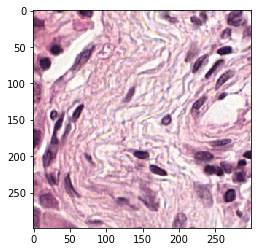

In [14]:
import time
import numpy as np
from PIL.Image import Image
from pylab import *
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

start_time = time.clock()

widths = 299
heights = 299

# 有效区域（感兴趣区域），所有细胞聚集区
effective_area = (effective_x, effective_y)
effective_area_size = (effective_widths, effective_heights)

# 有效区域，所有标注的细胞聚集区
# mask_slide.read_region(mask_tumor_start, 0, mask_tumor_area) 

# random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))  # 这一区域就是随机读到的区域，
                                                            #接下来就要判断这个区域在哪里，应该给他贴上什么标签

# 随机生成一个０到１之间的数，判断是否大于0.5,如果大于0.5,就从tumor区（mask）获取随机点（产生随机图片）；
# 如果小于0.5,就从normal区获取随机点，产生的随机图片需要判断是否取到了tumor
random_num = np.random.random(1)
print(random_num)

if random_num > 0.5:
    # 定义随机坐标,一定要取到一张含有tumor的图片
    random_x = np.random.randint(tumor_leftup_x, tumor_rightdown_x - widths)    # mask上的tumor有效区的起点和终点
    random_y = np.random.randint(tumor_leftup_y, tumor_rightdown_y - heights)
    print("取tumor随机点坐标是：%d,%d"%(random_x,random_y))
    random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
    random_img_mask_arr = array(random_img_mask.convert("L"))
    random__img_y, random_img_x = nonzero(random_img_mask_arr)
    while len(random_img_x)==0:
        random_x = np.random.randint(tumor_leftup_x, tumor_rightdown_x - widths)
        random_y = np.random.randint(tumor_leftup_y, tumor_rightdown_y - heights)
        print("取tumor随机点坐标是：%d,%d"%(random_x,random_y))
        random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
        random_img_mask_arr = array(random_img_mask.convert("L"))
        random__img_y, random_img_x = nonzero(random_img_mask_arr)
    
    #*********************上面这个 while 循环结束后，就产生了一个合格的坐标点*********************#
    random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))
    plt.imshow(random_img)
    #***接下来就给他贴标签，并处理成训练所需的数据结构***#
    random_img_arr = array(random_img.convert("RGB"))
    x = np.expand_dims(random_img_arr, axis=0)/255.
    y = to_categorical(0,2)    
else:
    # 定义随机坐标，一定要取到一张不含有tumor的normal图片
    random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)   # 大图上,nomal有效区的起点和终点
    random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)
    print("取normal随机点坐标是：%d,%d"%(random_x,random_y))
    random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
    random_img_mask_arr = array(random_img_mask.convert("L"))
    random__img_y, random_img_x = nonzero(random_img_mask_arr)
    while len(random_img_x) != 0:
        random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)
        random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)
        print("取normal随机点坐标是：%d,%d" %(random_x,random_y))
        random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
        random_img_mask_arr = array(random_img_mask.convert("L"))
        random__img_y, random_img_x = nonzero(random_img_mask_arr)
    
    #*********************上面这个 while 循环结束后，就产生了一个合格的坐标点*********************#
    random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))
    plt.imshow(random_img)
    #***接下来就给他贴标签，并处理成训练所需的数据结构***#
    random_img_arr = array(random_img.convert("RGB"))
    x = np.expand_dims(random_img_arr, axis=0)/255.
    y = to_categorical(1,2) 

end_time = time.clock()
print("本次执行时间是",end_time - start_time)
plt.show()